In [7]:
from denoising_net import Net, dev
from _utils import load_rgb_image, add_gaussian_noise, print_image

# quality metrics
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# utils for clipping
import numpy as np

from torch import Tensor, optim, from_numpy

In [8]:
# load and contaminate image
img_cpu = load_rgb_image('natural_images_selection/img_0')
img_cpu_numpy = img_cpu.numpy()

std = 0.15

noisy_img_cpu = add_gaussian_noise(img_cpu, avg=0, std=std)
noisy_img_dev = noisy_img_cpu.to(dev)
noisy_img_clipped = np.clip(noisy_img_cpu.numpy(), 0., 1.)

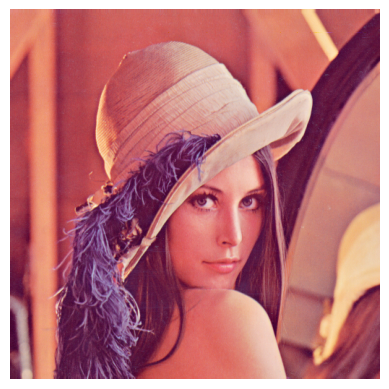

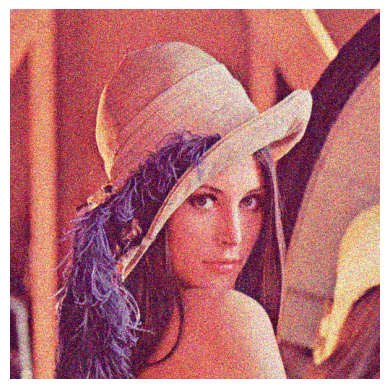

In [9]:
# show noisy image
print_image(img_cpu_numpy)
print_image(noisy_img_clipped)

Now, we
* randomly initialize our deep learning model,
* and generate the uniformly distributed input seed $U(0, \frac{1}{10})$ of shape $(32, 512, 512)$ (same width and height as input image).

Side-note: remember to cast to `float32`!

In [10]:
NN = Net().to(dev)
seed_cpu = from_numpy(np.random.uniform(low=0, high=0.1, size=(32, 512, 512)).astype('float32'))[None, :]

It's time for us to get everything ready w.r.t. the optimization loop. Consequently, we need to define
* which optimizer to use (in our case, Adam), and
* our learning rate.

As part of the optimization loop, in our work we also define a limit of iterations as well as a stopping criterion. This stopping criterion is based on the fact that, if $u$ is any given ground-truth image, and $n \sim \mathcal{N}(\mu=0, \sigma < +\infty)$, we then have the relationship
$$ \int_\Omega n^2 \, d\mathbf{x} = |\Omega| \sigma^2, $$
where $\Omega$ is the number of channel times the width and height of the input image. Consequently, if $f = u+n$ is the noisy "version" of $u$, we will stop when we have
$$ \int_\Omega (u^\ast-f)^2 \, d\mathbf{x} = |\Omega| \sigma^2, $$
where $u^\ast$ is the image generated by our neural network model. Finally, taking into account that we are dealing in a numeric scheme, we will actually stop whenever we have
$$ \int_\Omega (u^\ast-f)^2 \, d\mathbf{x} \leq |\Omega| \sigma^2. $$

We also may want to log our model's metrics as well as image quality metrics. For the purposes of this demo, we will log PSNR and SSIM values.

In [11]:
opt = optim.Adam(NN.parameters(), lr=1e-3)

iterations_limit = 10000

def error(img_approx: Tensor) -> Tensor:
    return (noisy_img_dev - img_approx).square().mean()

def stop(mse: float, std: float) -> bool:
    return mse < std ** 2

loss_log, psnr_log, ssim_log = [], [], []

We may now define the optimization loop however we see fit.

Images for iteration 0:


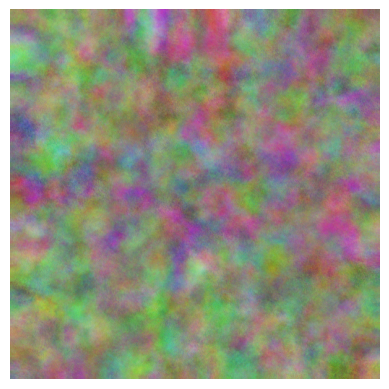

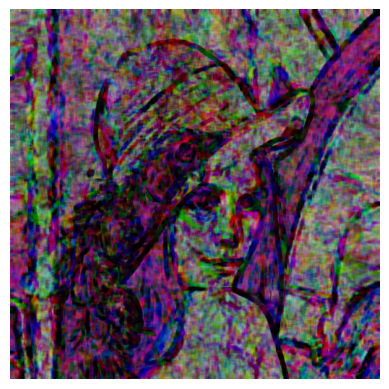

Images for iteration 50:


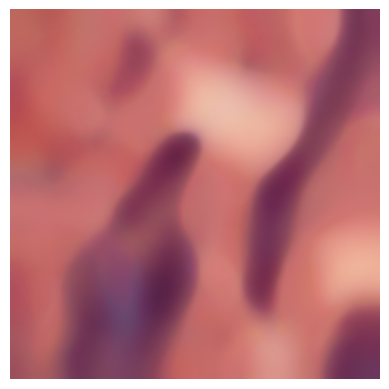

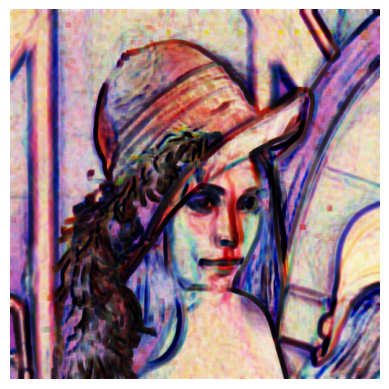

Images for iteration 100:


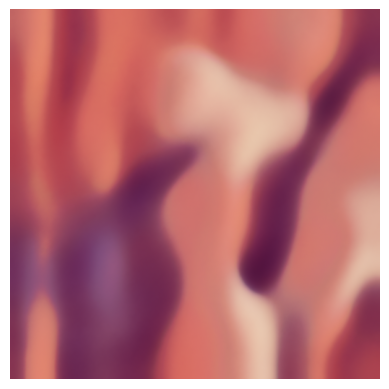

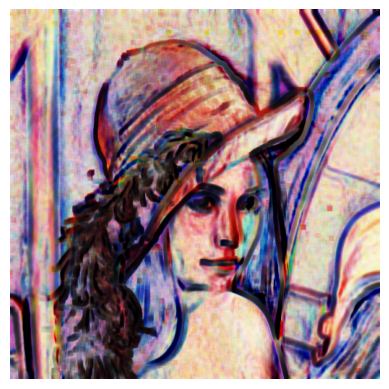

Images for iteration 150:


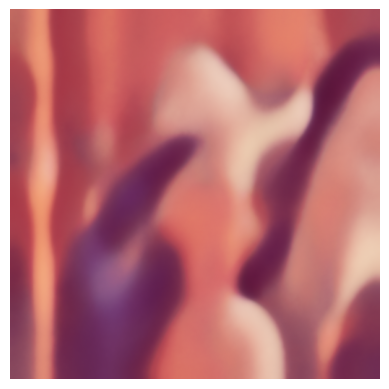

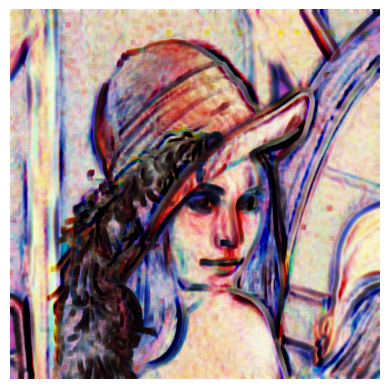

Images for iteration 200:


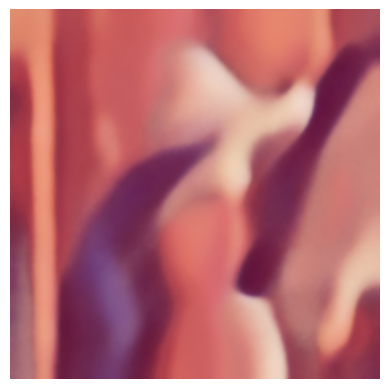

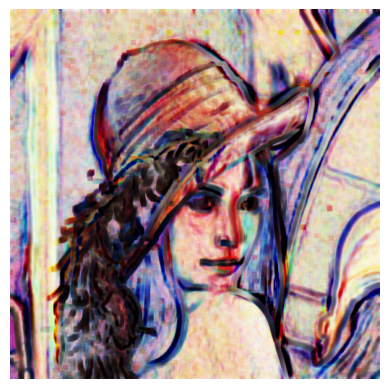

Images for iteration 250:


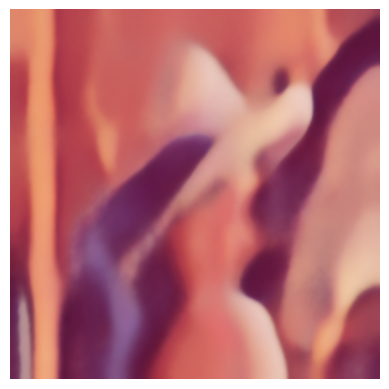

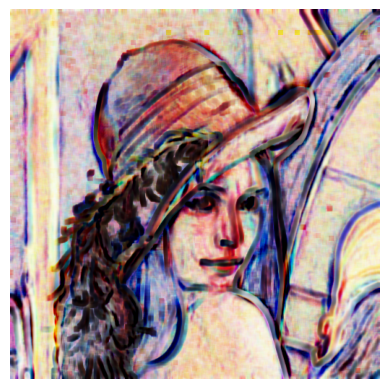

Images for iteration 500:


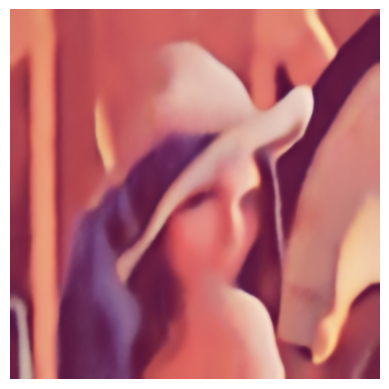

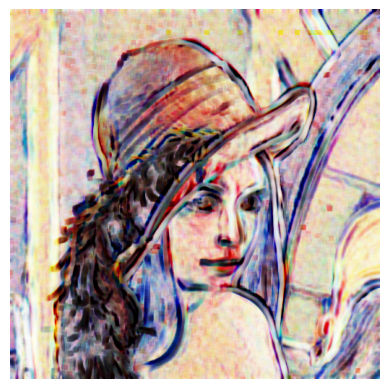

Images for iteration 1000:


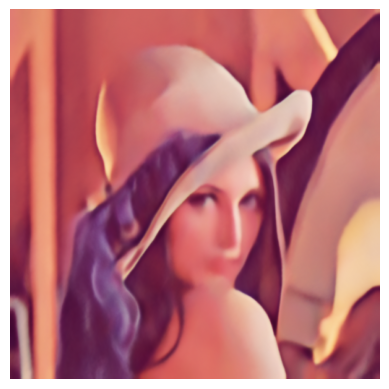

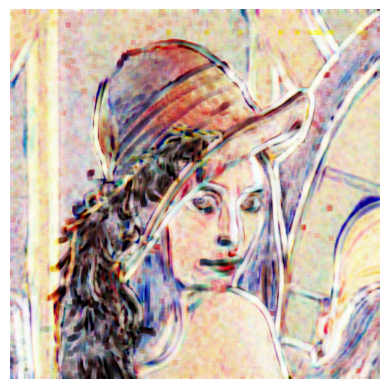

Images for iteration 1500:


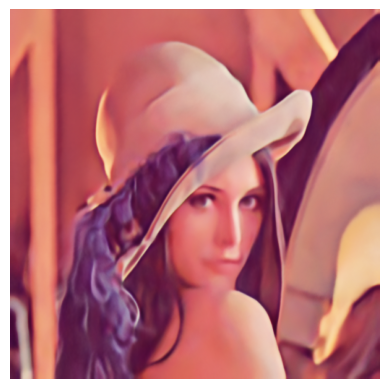

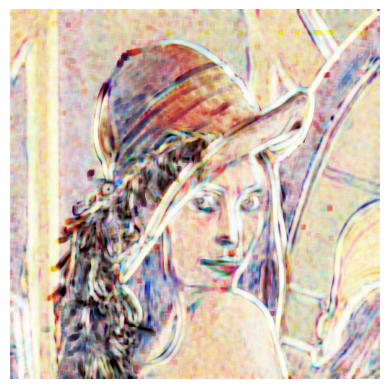

Images for iteration 2000:


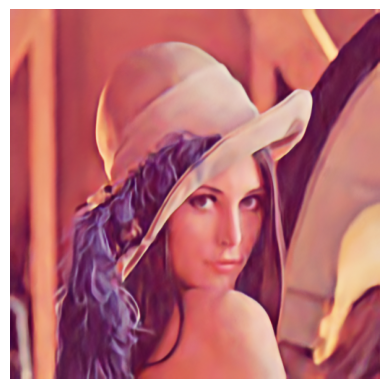

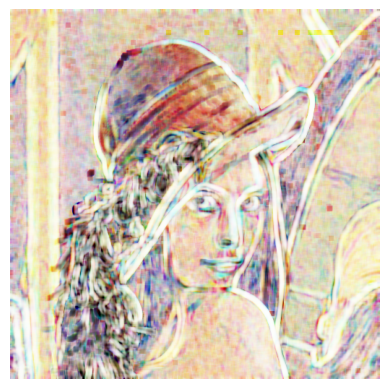

Images for iteration 2500:


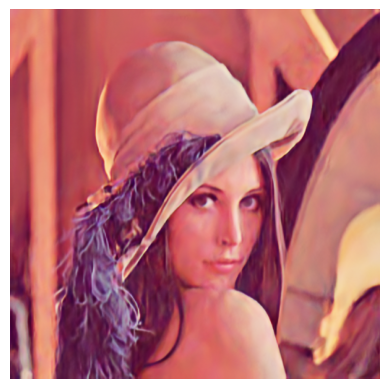

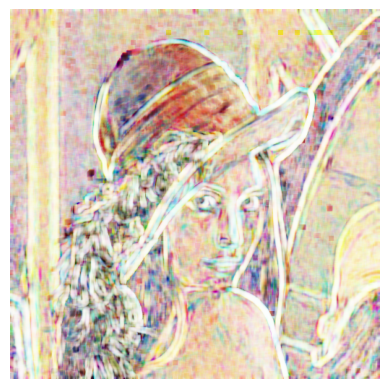

Images for iteration 2820:


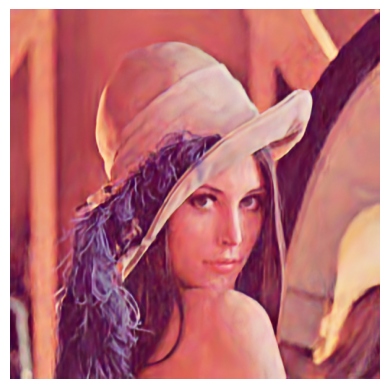

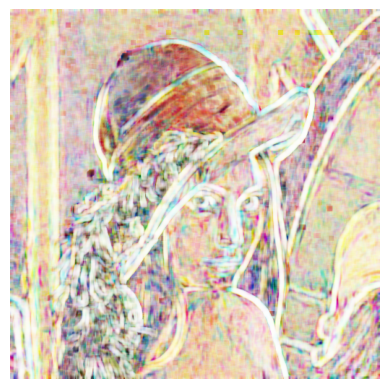

In [12]:
for it in range(iterations_limit):
    opt.zero_grad()

    # this iteration's noisy input
    noisy_seed_dev = add_gaussian_noise(seed_cpu, 0, 0.1).to(dev)

    # this iteration's image and loss
    img_approx = NN(noisy_seed_dev)
    loss = error(img_approx)

    # log numeric progress
        # ensure well-posedness of SSIM and PSNR by clipping outside of [0, 1]
    img_approx_clipped = np.clip(a=img_approx.cpu().detach()[0].numpy(), a_min=0.0, a_max=1.0) 
    loss_log.append(loss.cpu().detach().numpy())
    psnr_log.append(psnr(image_true=img_cpu_numpy, image_test=img_approx_clipped, data_range=1.0))
    ssim_log.append(ssim(img_cpu_numpy, img_approx_clipped, data_range=1.0, channel_axis=0))

    if it in np.arange(0, 300, 50) or it % 500 == 0 or stop(loss_log[-1], std): # show progress every few iterations
        print(f"Images for iteration {it}:")
        print_image(img_approx_clipped)
        _, img_ssim = ssim(img_cpu_numpy, img_approx_clipped, data_range=1.0, channel_axis=0, full=True)
        print_image(np.clip(a=img_ssim, a_min=0.0, a_max=1.0))

        if stop(loss_log[-1], std):
            break

    # update gradients
    loss.backward()
    opt.step()

Finally, we show our results for this model's curves:

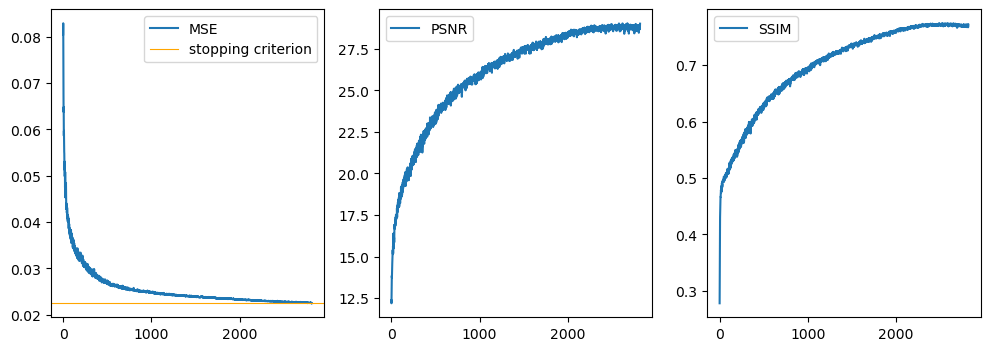

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(loss_log, label="MSE")
axes[0].axhline(std**2, linewidth=.8, label="stopping criterion", c="orange")
axes[0].legend()
axes[1].plot(psnr_log, label="PSNR")
axes[1].legend()
axes[2].plot(ssim_log, label="SSIM")
axes[2].legend()

plt.show()